In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
training_data = pd.read_csv("data/train_base.csv")
test_data = pd.read_csv("data/test_base.csv")


In [3]:
training_data.head()


,ID,Cycle,S1,S2,S3,S4,TTF,TTF_LABEL
0,1,1,1400.60,554.36,47.47,521.66,191,0
1,1,2,1403.14,553.75,47.49,522.28,190,0
2,1,3,1404.20,554.26,47.27,522.42,189,0
3,1,4,1401.87,554.45,47.13,522.86,188,0
4,1,5,1406.22,554.00,47.28,522.19,187,0


In [4]:
test_data.head()


,ID,Cycle,S1,S2,S3,S4,TTF,TTF_LABEL
0,1,31,1398.91,554.42,47.23,521.79,112,0
1,2,49,1410.83,553.52,47.67,521.74,98,0
2,3,126,1418.89,552.59,47.88,520.83,69,0
3,4,106,1406.88,552.64,47.65,521.88,82,0
4,5,98,1419.36,553.29,47.46,521.00,91,0


In [5]:
# Define features and target
features = ["S1", "S2", "S3", "S4"]
target = "TTF_LABEL"


In [6]:
X_train = training_data[features]
y_train = training_data[target]

X_test = test_data[features]
y_test = test_data[target]


In [7]:
X_train.head()


,S1,S2,S3,S4
0,1400.60,554.36,47.47,521.66
1,1403.14,553.75,47.49,522.28
2,1404.20,554.26,47.27,522.42
3,1401.87,554.45,47.13,522.86
4,1406.22,554.00,47.28,522.19


In [8]:
y_train.head()


0    0
1    0
2    0
3    0
4    0
Name: TTF_LABEL, dtype: int64

## Helper Methods

### Hyperparameter Tuning

In [55]:
def tune_hyperparameters(
    classifier, parameters_grid, X_train, y_train, cv=5, score=None
):
    """Tune the hyperparameters of a regression model using Grid Search

    Args:
        regressor (str): The model name identifier
        parameters_grid (dict): The hyperparameters grid
        X_train (dataframe): The training features
    """
    grid = GridSearchCV(classifier, parameters_grid, cv=cv, scoring=score)
    grid.fit(X_train, y_train)
    print(
        f"The best parameters are {grid.best_params_} with a score of {grid.best_score_}"
    )
    return grid.best_estimator_

### Generate prediction scores

In [37]:
def generate_scores(classifer, X_train, y_train):
    """Generate the scores of the model

    Args:
        classifer (str): The model name identifier
        X_train (dataframe): The training features
        y_train (dataframe): The training target
    """
    return classifer.predict_proba(X_train)[:, 1], classifer.predict_proba(X_test)[:, 1]

### Classification Metrics
Metrics to be considered:
- Accuracy
- Precision
- Recall
- F1
- ROC AUC

In [40]:
def calculate_classification_metrics(model_name, training_actual, training_predictions, training_scores, test_actual, test_predictions, test_scores):
    """Calculate the classification metrics

    Args:
        model_name (str): The model name identifier
        training_actual (dataframe): The training actual values
        training_predictions (dataframe): The training predicted values
        test_actual (dataframe): The test actual values
        test_predictions (dataframe): The test predicted values
    """
    training_metrics = {
        "Accuracy": accuracy_score(training_actual, training_predictions),
        "Precision": precision_score(training_actual, training_predictions),
        "Recall": recall_score(training_actual, training_predictions),
        "F1": f1_score(training_actual, training_predictions),
        "ROC AUC": roc_auc_score(training_actual, training_scores),
    }

    test_metrics = {
        "Accuracy": accuracy_score(test_actual, test_predictions),
        "Precision": precision_score(test_actual, test_predictions),
        "Recall": recall_score(test_actual, test_predictions),
        "F1": f1_score(test_actual, test_predictions),
        "ROC AUC": roc_auc_score(test_actual, test_scores),
    }

    metrics = {
        f"{model_name} (Training)": training_metrics,
        f"{model_name} (Test)": test_metrics
    }

    return pd.DataFrame.from_dict(metrics)


### Plot Confusion Matrix

In [13]:
def plot_confusion_matrix(
    actual, predicted, cmap="Blues"):
    """Plot the confusion matrix

    Args:
        actual (array): The actual values
        predicted (array): The predicted values
        cmap (str): The color map
    """
    cm = confusion_matrix(actual, predicted)
    group_labels = ["True Positive", "False Positive", "False Negative", "True Negative"]
    counts = [
        "{0:0.0f}".format(value) for value in cm.flatten()
    ]
    percentages = [
        "{0:.2%}".format(value)
        for value in cm.flatten() / np.sum(cm)
    ]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_labels, counts, percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, fmt="", cmap=cmap)

### Plot ROC Curve

In [ ]:
def plot_roc(model_name, classifier, actual, predicted):
    """Plot the ROC curve

    Args:
        model_name (str): The model name identifier
        classifier (str): The classifier 
        actual (array): The actual values
        predicted (array): The predicted values
    """
    fpr, tpr, threshold = roc_curve(actual, predicted)

## Logistic Regression

In [69]:
# Perform grid search on logistic regression
c_space = [.01, 0.1, 1.0, 10]
parameters_grid = { "C": c_space }
tuned_logistic_classifier = tune_hyperparameters(LogisticRegression(), parameters_grid, X_train, y_train, score='roc_auc')

The best parameters are {'C': 10} with a score of 0.9801424294609669


In [70]:
# Fit the classifier and predict on test data
training_predictions = tuned_logistic_classifier.predict(X_train)
test_predictions = tuned_logistic_classifier.predict(X_test)

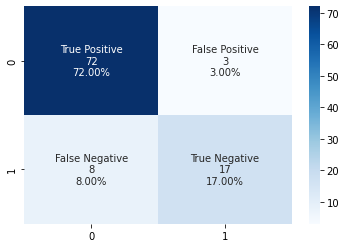

In [71]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, test_predictions)

In [65]:
# Calculate the classification metrics
prediction_probabilities_training, prediction_probabilities_test = generate_scores(tuned_logistic_classifier, X_train, y_train)
logistic_regression_classification_metrics = calculate_classification_metrics('Logistic Regression', y_train, training_predictions, prediction_probabilities_training, y_test, test_predictions, prediction_probabilities_test)
logistic_regression_classification_metrics

,Logistic Regression (Training),Logistic Regression (Test)
Accuracy,0.946973,0.890000
Precision,0.848022,0.850000
Recall,0.788387,0.680000
F1,0.817118,0.755556
ROC AUC,0.979188,0.959467


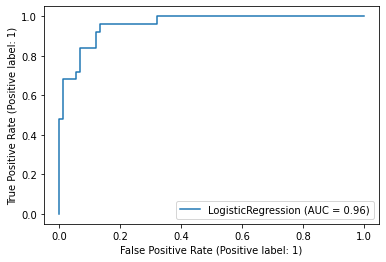

In [92]:
RocCurveDisplay.from_estimator(tuned_logistic_classifier, X_test, y_test)

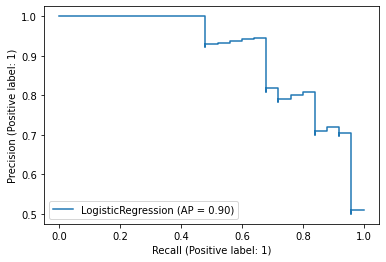

In [73]:
PrecisionRecallDisplay.from_estimator(tuned_logistic_classifier, X_test, y_test)

## Decision Tree classification

In [76]:
# Perform grid search on decision tree
max_depth_space = [2, 3, 4, 5, 6, 7, 8]
criterion_space = ["gini", "entropy"]
parameters_grid = { "max_depth": max_depth_space, "criterion": criterion_space }
tuned_decision_tree_classifier = tune_hyperparameters(DecisionTreeClassifier(), parameters_grid, X_train, y_train, score='roc_auc')

The best parameters are {'criterion': 'entropy', 'max_depth': 4} with a score of 0.9735171572097878


In [80]:
# Make predictions on training and test data
training_predictions = tuned_decision_tree_classifier.predict(X_train)
test_predictions = tuned_decision_tree_classifier.predict(X_test)
prediction_probabilities_training, prediction_probabilities_test = generate_scores(tuned_decision_tree_classifier, X_train, y_train)

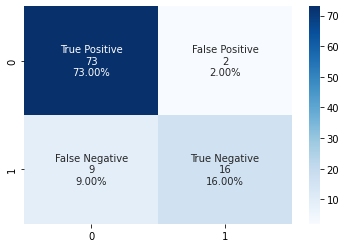

In [81]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, test_predictions)

In [82]:
# Calculate the classification metrics
decision_tree_classification_metrics = calculate_classification_metrics('Decision Tree', y_train, training_predictions, prediction_probabilities_training, y_test, test_predictions, prediction_probabilities_test)
decision_tree_classification_metrics

,Decision Tree (Training),Decision Tree (Test)
Accuracy,0.943677,0.890000
Precision,0.885748,0.888889
Recall,0.717742,0.640000
F1,0.792944,0.744186
ROC AUC,0.976331,0.945333


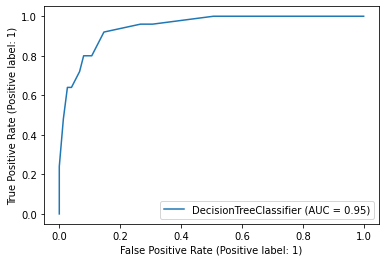

In [93]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(tuned_decision_tree_classifier, X_test, y_test)

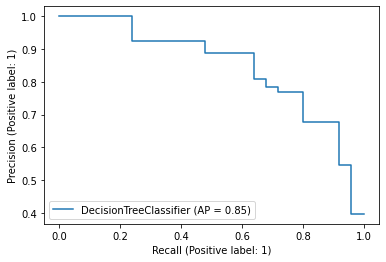

In [94]:
# Plot precision-recall curve
PrecisionRecallDisplay.from_estimator(tuned_decision_tree_classifier, X_test, y_test)

## Random Forest classification

In [102]:
# Perform grid search on random forest
max_depth_space = [2, 3, 4, 5, 6, 7, 8]
criterion_space = ["gini", "entropy"]
parameters_grid = { "max_depth": max_depth_space, "criterion": criterion_space }

tuned_random_forest_classifier = tune_hyperparameters(RandomForestClassifier(random_state=42), parameters_grid, X_train, y_train, score='roc_auc')


The best parameters are {'criterion': 'entropy', 'max_depth': 5} with a score of 0.979874482097238


In [103]:
# Make predictions on training and test data
training_predictions = tuned_random_forest_classifier.predict(X_train)
test_predictions = tuned_random_forest_classifier.predict(X_test)
prediction_probabilities_training, prediction_probabilities_test = generate_scores(tuned_random_forest_classifier, X_train, y_train)

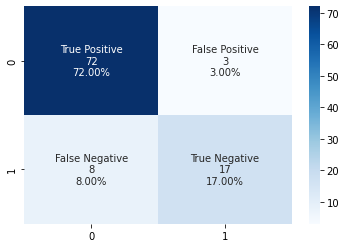

In [104]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, test_predictions)

In [105]:
# Calculate the classification metrics
random_forest_classification_metrics = calculate_classification_metrics('Random Forest', y_train, training_predictions, prediction_probabilities_training, y_test, test_predictions, prediction_probabilities_test)
random_forest_classification_metrics

,Random Forest (Training),Random Forest (Test)
Accuracy,0.948427,0.890000
Precision,0.862794,0.850000
Recall,0.780968,0.680000
F1,0.819844,0.755556
ROC AUC,0.981679,0.955733


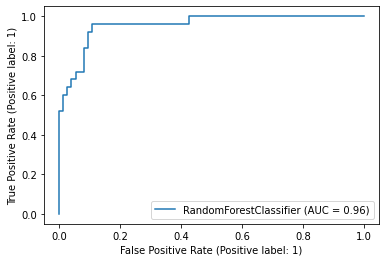

In [110]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(tuned_random_forest_classifier, X_test, y_test)

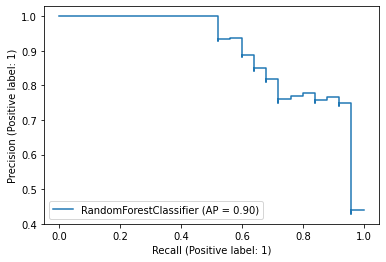

In [111]:
# Plot precision-recall curve
PrecisionRecallDisplay.from_estimator(tuned_random_forest_classifier, X_test, y_test)

## K-Nearest Neighbors

In [116]:
# Perform grid search on KNN
n_neighbors_space = [6, 7, 8, 9, 10, 11, 12, 13, 14]
parameters_grid = { "n_neighbors": n_neighbors_space }
tuned_knn_classifier = tune_hyperparameters(KNeighborsClassifier(), parameters_grid, X_train, y_train, score='roc_auc')

The best parameters are {'n_neighbors': 14} with a score of 0.9620683849374811


In [117]:
# Make predictions on training and test data
training_predictions = tuned_knn_classifier.predict(X_train)
test_predictions = tuned_knn_classifier.predict(X_test)
prediction_probabilities_training, prediction_probabilities_test = generate_scores(tuned_knn_classifier, X_train, y_train)

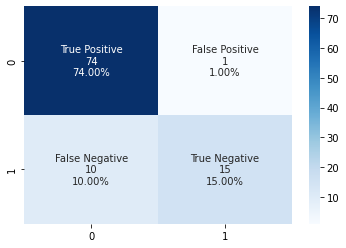

In [118]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, test_predictions)

In [119]:
# Calculate the classification metrics
knn_classification_metrics = calculate_classification_metrics('KNN', y_train, training_predictions, prediction_probabilities_training, y_test, test_predictions, prediction_probabilities_test)
knn_classification_metrics

,KNN (Training),KNN (Test)
Accuracy,0.946925,0.890000
Precision,0.868431,0.937500
Recall,0.762258,0.600000
F1,0.811888,0.731707
ROC AUC,0.982859,0.928267


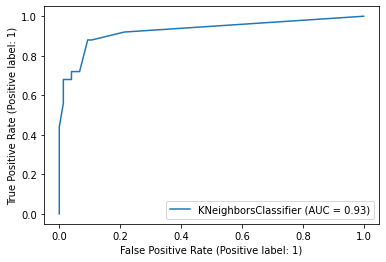

In [120]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(tuned_knn_classifier, X_test, y_test)

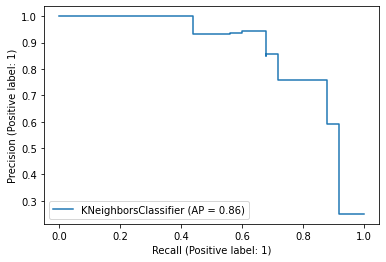

In [121]:
# Plot precision-recall curve
PrecisionRecallDisplay.from_estimator(tuned_knn_classifier, X_test, y_test)

## Support Vector Machine classification

In [124]:
# Perform grid search on SVM
c_space = [.001, .01 ,.1 , 1, 10, 20, 100]
parameters_grid = { 'C' : c_space }
tuned_svm = tune_hyperparameters(SVC(), parameters_grid, X_train, y_train, score='roc_auc')

The best parameters are {'C': 100} with a score of 0.9674415327955659


In [ ]:
# Make predictions on training and test data
training_predictions = tuned_svm.predict(X_train)
test_predictions = tuned_svm.predict(X_test)
prediction_probabilities_training, prediction_probabilities_test = generate_scores(tuned_svm, X_train, y_train)

In [125]:
# Calculate the classification metrics
svm_classification_metrics = calculate_classification_metrics('SVM', y_train, training_predictions, prediction_probabilities_training, y_test, test_predictions, prediction_probabilities_test)
svm_classification_metrics

,SVM (Training),SVM (Test)
Accuracy,0.946925,0.890000
Precision,0.868431,0.937500
Recall,0.762258,0.600000
F1,0.811888,0.731707
ROC AUC,0.982859,0.928267


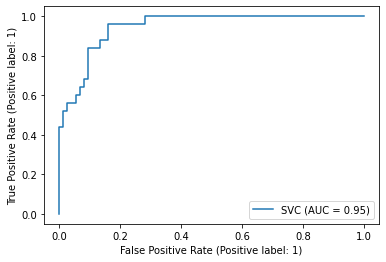

In [126]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(tuned_svm, X_test, y_test)

## Gaussian Naive Bayes

In [127]:
# Define the naive bayes model and fit it to the training data
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)

GaussianNB()

In [128]:
# Make predictions on training and test data
training_predictions = naive_bayes_model.predict(X_train)
test_predictions = naive_bayes_model.predict(X_test)
prediction_probabilities_training, prediction_probabilities_test = generate_scores(naive_bayes_model, X_train, y_train)

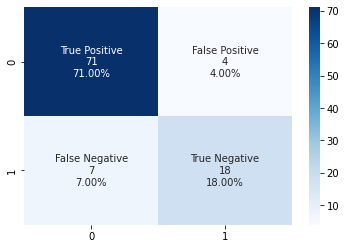

In [129]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, test_predictions)

In [131]:
# Calculate the classification metrics
naive_bayes_classification_metrics = calculate_classification_metrics('Naive Bayes', y_train, training_predictions, prediction_probabilities_training, y_test, test_predictions, prediction_probabilities_test)
naive_bayes_classification_metrics

,Naive Bayes (Training),Naive Bayes (Test)
Accuracy,0.930687,0.890000
Precision,0.711392,0.818182
Recall,0.906452,0.720000
F1,0.797163,0.765957
ROC AUC,0.979059,0.959467


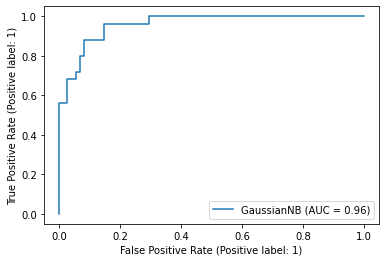

In [132]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(naive_bayes_model, X_test, y_test)

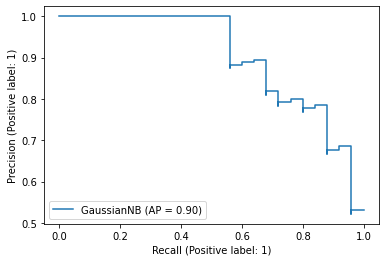

In [133]:
# Plot precision-recall curve
PrecisionRecallDisplay.from_estimator(naive_bayes_model, X_test, y_test)

# Comparison of Classification Algorithms

In [134]:
metrics = pd.concat([logistic_regression_classification_metrics, decision_tree_classification_metrics, random_forest_classification_metrics, knn_classification_metrics, svm_classification_metrics, naive_bayes_classification_metrics], axis=1)
test_metrics = metrics.filter(like="(Test)", axis=1)
test_metrics

,Logistic Regression (Test),Decision Tree (Test),Random Forest (Test),KNN (Test),SVM (Test),Naive Bayes (Test)
Accuracy,0.890000,0.890000,0.890000,0.890000,0.890000,0.890000
Precision,0.850000,0.888889,0.850000,0.937500,0.937500,0.818182
Recall,0.680000,0.640000,0.680000,0.600000,0.600000,0.720000
F1,0.755556,0.744186,0.755556,0.731707,0.731707,0.765957
ROC AUC,0.959467,0.945333,0.955733,0.928267,0.928267,0.959467
